In [1]:
# notebook to test on lab 6 data

## Setup and Filtering the Data

In [23]:
# import libraries
import sys
import os
sys.path.append(os.environ["HOME"]+"/.local/lib/python3.9/site-packages")
import scanpy as sc, anndata as ad
import harmonypy
import leidenalg
import numpy as np
import pandas as pd
# from sklearn.datasets import make_blobs

In [24]:
# diSNE packages 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, squareform

In [7]:
# check imports
sc.logging.print_versions()

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                 8.3.1
anyio               NA
attr                21.2.0
babel               2.9.1
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.2
brotli              NA
certifi             2022.12.07
cffi                1.14.6
chardet             4.0.0
charset_normalizer  2.0.0
cloudpickle         1.6.0
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.06.2
dateutil            2.8.2
debugpy             1.6.7
decorator           5.0.9
defusedxml          0.7.1
entrypoints         0.3
fastjsonschema      NA
fsspec              2021.07.0
google              NA
h5py                3.3.0
harmonypy           NA
idna                3.1
igraph              0.11.4
ipykernel           6.17.1
ipython_genutils    0.2.0
jedi                0.18.0
jinja2              3.0.1
joblib              1.0.1
json5               NA
j

In [9]:
# concatenate all three datasets into single anndata object
DATADIR=os.environ["HOME"]+"/public/lab6"
dsets = ["GSM5114461_S6_A11", "GSM5114464_S7_D20", "GSM5114474_M3_E7"]
adatas = {}
for ds in dsets:
    print(ds)
    adatas[ds] = sc.read_10x_mtx(DATADIR, prefix=ds+"_", cache=True)
combined = ad.concat(adatas, label="dataset")
combined.obs_names_make_unique()

GSM5114461_S6_A11
GSM5114464_S7_D20
GSM5114474_M3_E7


/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
# print out the dimensions of the combined dataset loaded
combined

AnnData object with n_obs × n_vars = 12357 × 20621
    obs: 'dataset'

In [11]:
# filtering steps
# filter cells that have less than 200 genes expressed
sc.pp.filter_cells(combined, min_genes=200)
# filter cells with less than 1000 total reads 
sc.pp.filter_cells(combined, min_counts=1000)
# filter genes that are detected in less than 5 cells
sc.pp.filter_genes(combined, min_cells=5)
# genes that have a total count of less than 15
sc.pp.filter_genes(combined, min_counts=15)

In [12]:
# confirm filtering
combined

AnnData object with n_obs × n_vars = 10133 × 15779
    obs: 'dataset', 'n_genes', 'n_counts'
    var: 'n_cells', 'n_counts'

In [13]:
# filter out high mitochondrial counts
# compute percent of counts in each cell that are from mitochondrial genes
# annotate the group of mitochondrial genes as "mt"
combined.var["mt"] = combined.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    combined, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
# filter cells with high percentage of counts from mitochondrial genes
# 25% as threshold
# i might have done this wrong
adata_filt = combined[combined.obs.n_genes_by_counts<2500, :]
adata_filt = adata_filt[adata_filt.obs.pct_counts_mt<25, :].copy() 

In [14]:
# normalize counts
# total-count normalize data matrix to 10,000 reads per cell
sc.pp.normalize_per_cell(adata_filt, counts_per_cell_after=1e4)
# log transform data
sc.pp.log1p(adata_filt)

In [15]:
# identify highly variable genes
    # options: 
    # batch_key="dataset" <- select highly variable genes separately within the 3 datasets
    # n_top_genes=500 <- select only the top 500 most variable genes
sc.pp.highly_variable_genes(adata_filt, batch_key="dataset", n_top_genes=500)

In [16]:
# create new AnnData object for analyses with:
# only highly variable genes
# genes with specific marker genes from paper (manually add back even if not most differentially expressed)
genes = ["GCG", "TTR",  "IAPP",  "GHRL", "PPY", "COL3A1",
    "CPA1", "CLPS", "REG1A", "CTRB1", "CTRB2", "PRSS2", "CPA2", "KRT19", "INS","SST","CELA3A", "VTCN1"]

adata_var = adata_filt[:, (adata_filt.var.index.isin(genes) | adata_filt.var["highly_variable"])]

In [17]:
# remove batch effects (skip this???)
# visualize batch effects
# perform PCA on dataset and plot data along the first 2 PCs
# compute first 20 PCs
sc.pp.pca(adata_var, n_comps=20)

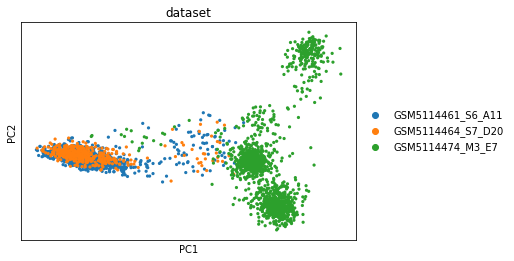

In [18]:
sc.pl.pca(adata_var, color="dataset")

## Clustering and Visualization using t-SNE

In [19]:
# identify individual cell types/visualize results
# perform clustering using scanpy
# computes neighborhood graphs, needed to run clustering
sc.pp.neighbors(adata_var) 

In [20]:
# clusters cells based on expression profiles, needed to color cells by cluster
sc.tl.leiden(adata_var) 

In [ ]:
# PERFORM t-SNE -- OUR CODE HERE

In [21]:
# Step 1: Compute pairwise distances
def pairwise_distances(X):
    return squareform(pdist(X, 'euclidean'))

# Step 2: Compute joint probabilities P in high-dimensional space
def compute_joint_probabilities(distances, perplexity=30.0):
    (n, _) = distances.shape
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)
    
    for i in range(n):
        betamin = -np.inf
        betamax = np.inf
        Di = distances[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        H, thisP = Hbeta(Di, beta[i])
        
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > 1e-5 and tries < 50:
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf:
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                if betamin == -np.inf:
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2
            
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP
    
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = np.maximum(P, 1e-12)
    return P

def Hbeta(D, beta):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

# Step 3: Initialize embedding Y
def initialize_embedding(n, dim=2):
    return np.random.randn(n, dim)

# Step 4: Compute low-dimensional affinities Q
def compute_low_dim_affinities(Y):
    distances = pairwise_distances(Y)
    inv_distances = 1 / (1 + distances)
    np.fill_diagonal(inv_distances, 0)
    inv_distances_sum = np.sum(inv_distances)
    Q = inv_distances / (inv_distances_sum + 1e-12)  # Add epsilon to avoid division by zero
    Q = np.maximum(Q, 1e-12)
    return Q

# Step 5: Compute gradients and update embedding
def compute_gradients(P, Q, Y):
    n, dim = Y.shape
    dY = np.zeros((n, dim))
    PQ_diff = P - Q
    for i in range(n):
        dY[i, :] = 4 * np.sum((PQ_diff[:, i].reshape(-1, 1) * (Y[i, :] - Y)), axis=0)
    return dY

def update_embedding(Y, dY, learning_rate=200.0):
    # Normalize the gradients
    grad_norm = np.linalg.norm(dY, axis=1, keepdims=True)
    dY = dY / (grad_norm + 1e-12)
    
    # Clip the gradients to prevent excessively large updates
    max_step_size = 1.0
    dY = np.clip(dY, -max_step_size, max_step_size)
    
    return Y - learning_rate * dY

# Step 6: The main t-SNE function modified to store results in adata.obsm['X_tsne']
def tsne(adata, perplexity=30.0, n_iter=1000, learning_rate=10.0):
    X = adata.X
    distances = pairwise_distances(X)
    P = compute_joint_probabilities(distances, perplexity)
    Y = initialize_embedding(X.shape[0])
    
    for iter in range(n_iter):
        Q = compute_low_dim_affinities(Y)
        dY = compute_gradients(P, Q, Y)
        Y = update_embedding(Y, dY, learning_rate)
        
        if iter % 100 == 0:
            cost = np.sum(P * np.log(P / Q))
            # Uncomment the next line if you want to see the progress
            # print(f"Iteration {iter}: cost = {cost}")
            pass
    
    # Store the resulting t-SNE embedding in adata.obsm['X_tsne']
    adata.obsm['X_tsne'] = Y

In [25]:
tsne(adata_var)

ValueError: Sparse matrices are not supported by this function. Perhaps one of the scipy.sparse.linalg functions would work instead.

In [26]:
def plot_tsne_results(adata, feature, title='t-SNE results', figsize=(10, 8)):
    tsne_out = adata.obsm['X_tsne']
    labels = adata.obs[feature].astype(int).values
    plt.figure(figsize=figsize)
    scatter = plt.scatter(tsne_out[:, 0], tsne_out[:, 1], c=labels, cmap='viridis', marker='o')
    if labels is not None:
        plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.colorbar()
    plt.show()

In [ ]:
# Extract t-SNE results and cluster labels
tsne_out = adata_var.obsm['X_tsne']
clusters = adata_var.obs['leiden'].astype(int).values  # Cluster labels

# Plot the t-SNE results
plot_tsne_results(adata, feature='leiden')